In [1]:
from kitti_detection import config
from kitti_detection.dataset import DataSample, class_names, class_counts, load_train_val_test_dataset
from kitti_detection.utils import display_samples_h

import torch
from torch import nn, optim, Tensor
import torch.nn.init as init
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.tv_tensors import BoundingBoxes
from torchvision.ops.roi_pool import RoIPool
from torchvision.models import vgg16, VGG16_Weights
from torchvision.ops import box_iou

import cv2
import numpy as np

from typing import Optional

# Neuer Abschnitt

In [2]:
torch.cuda.is_available()

True

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu") 

print(DEVICE)

cuda


In [4]:
torch.__version__

'2.3.0+cu121'

In [5]:
transforms = v2.Compose([
    v2.RandomCrop(size=(370, 370)),
    #v2.Resize((224, 224)),
    v2.ToTensor(),  # Convert PIL Image to Tensor
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),  # Normalize to [0, 1]
    v2.SanitizeBoundingBoxes(min_size=15.0)
])

/home/torcsa/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
train_dataset, val_dataset, test_dataset = load_train_val_test_dataset()

train_dataset.transform = transforms
val_dataset.transform = transforms

/data/image/train


In [7]:
n_classes = len(class_names)

<class 'list'>
[tensor([[[-0.0287, -0.2171, -0.3369,  ..., -1.5014, -1.4500, -1.4500],
         [-0.5082, -0.6794, -0.5767,  ..., -1.4329, -1.3987, -1.3987],
         [-0.6281, -0.7308, -0.6109,  ..., -1.4329, -1.4158, -1.4329],
         ...,
         [ 0.6906,  0.7077,  0.7591,  ..., -1.4843, -1.6898, -1.7240],
         [ 0.7248,  0.6906,  0.6906,  ..., -1.3473, -1.6898, -1.8439],
         [ 1.2385,  1.2557,  1.0331,  ..., -1.2274, -1.4843, -1.7412]],

        [[ 0.1702, -0.2150, -0.4076,  ..., -1.4930, -1.5105, -1.4930],
         [ 0.3978, -0.0924, -0.0749,  ..., -1.4755, -1.4755, -1.4930],
         [-0.5126, -0.1975, -0.5301,  ..., -1.4580, -1.4755, -1.4930],
         ...,
         [ 0.8704,  0.9055,  0.9230,  ..., -1.5455, -1.5455, -1.5805],
         [ 0.9755,  0.9580,  0.9405,  ..., -1.5280, -1.5980, -1.5980],
         [ 1.2381,  1.1155,  1.0980,  ..., -1.3004, -1.4405, -1.5105]],

        [[ 0.2173, -0.1487, -0.6890,  ..., -1.3687, -1.3687, -1.4036],
         [ 0.5485, -0.1312, -

/home/torcsa/.local/lib/python3.10/site-packages/torchvision/utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
/home/torcsa/.local/lib/python3.10/site-packages/torchvision/utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


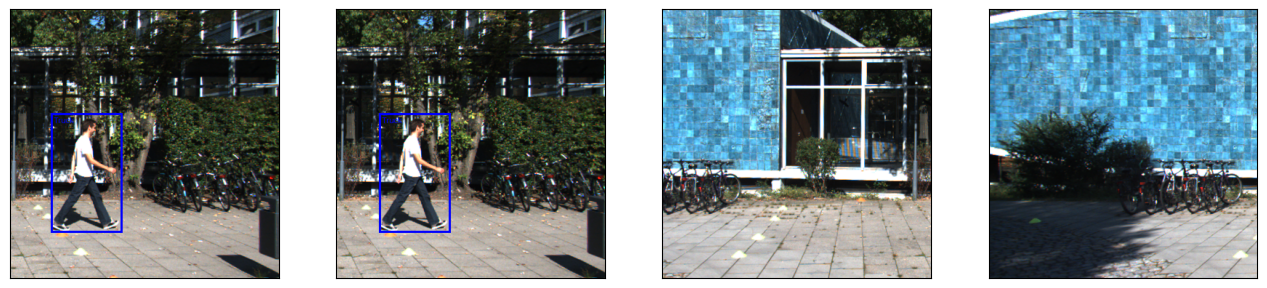

In [8]:
data_loader = DataLoader(train_dataset, batch_size=None, shuffle=False)
elements = next(iter(data_loader))
print(type(elements))
print(elements)
for element in elements:
    print(type(element))
    #print(element)
display_samples_h([next(iter(data_loader)) for _ in range(4)])

**VGG16**
<br>
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*0M8CobXpNwFDCmOQ">

In [9]:
def new_forward(model, x: torch.Tensor) -> torch.Tensor:
        x = model.features(x)
        # Skipping the flattening, the average pooling and the original classifier
        return x

In [10]:
def convert_rois(rois: torch.Tensor) -> torch.Tensor:
    # Create a tensor of zeros with shape [64, 1]
    zeros_column = torch.zeros(64, 1)
    zeros_column = zeros_column.to(DEVICE)

    final_rois = torch.cat((zeros_column, rois), dim=1)
    return final_rois

In [11]:
class FastRCNN(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.dropout=0.5

        self.roi_pool = RoIPool(output_size=(7, 7), spatial_scale=23/370) # Input: 224 * 224 | roi input: 14 * 14 -> 14/224 = 0.0625
        self.conv = self._prepare_vgg16()
        self.fc = nn.Sequential(
            nn.Linear(in_features=512 * 7 * 7, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(p=self.dropout),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=n_classes + 1)
        )
        self.bbox_regressor = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=4)
        )

    def _prepare_vgg16(self, weights: Optional[VGG16_Weights] = None) -> nn.Module:
        vgg16 = models.vgg16(weights)
        #vgg16 = vgg16.to(DEVICE)

        # Replace the existing forward method
        vgg16.forward = lambda x: new_forward(vgg16, x)

        vgg16.features[-1] = nn.Identity()
        vgg16.avgpool = nn.Identity()
        vgg16.classifier = nn.Identity()

        return vgg16

    def forward(self, x):
        # Model input: tuple of 1. single image tensor 2. BoundingBoxes tensor of region proposal ROIs

        #if isinstance(x, tuple) and len(x) == 2:
        #    if not isinstance(x[0], Tensor):
        #        raise TypeError("Expected the first element of the tuple to be a torch.Tensor")
        #    if not isinstance(x[1], list):
        #        raise TypeError("Expected the second element of the tuple to be a list (of BoundingBoxes)")
        #else:
        #    raise TypeError("Expected a tuple containing (Tensor, BoundingBoxes)")

        img, rois = x

        img = img.to(DEVICE)
        rois = rois.to(DEVICE)
        
        rois = convert_rois(rois)
        

        #print(f'Max value image: {torch.max(img)}')
        #print(img)
        #assert not torch.isnan(img).any(), "Input contains NaN values"

        fmap = self.conv(img)

        #print(f'Max value fmap: {torch.max(fmap)}')
        #print(f'input - Max value rois: {torch.max(rois)}')
        #print('Feature map')
        #print(fmap)
        #if torch.isnan(fmap).any():
        #    nan_indices = torch.isnan(fmap)
        #    fmap[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('fmap HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(fmap)
        #print(f'FMAP shape: {fmap.shape}')
        # Shape if [1, 512, 7, 7]
        #rois = rois.to(DEVICE)
        #print(f'shape of rois: {rois.shape}')
        # Shape is [64, 5]


        windows = self.roi_pool(fmap, rois=rois)

        #print('ROIS:')
        #print(rois)
        #print(f'Max value windows1: {torch.max(windows)}')
        #print(windows)
        #if torch.isnan(windows).any():
        #    nan_indices = torch.isnan(windows)
        #    windows[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('windows1 HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(windows)
        #print(f'shape of output of roi pool: {windows.shape}')
        # Shape is [64, 512, 7, 7]
        #return None, None
        #assert not torch.isnan(windows).any(), "Input contains NaN values"
        #print(f'flatten: {windows}')
        #print(f'shape of flatten: {windows.shape}')
        #print(f'type of flatten: {type(windows)}')
        #windows_cpu = windows.cpu()
        #print(windows_cpu.device)

        windows = torch.flatten(windows, start_dim=1)

        #print('Windows2')
        #print(f'Max value windows2: {torch.max(windows)}')
        #print(windows)
        #if torch.isnan(windows).any():
        #    nan_indices = torch.isnan(windows)
        #    windows[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('windows2 HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(windows)
        #print(f'shape after flatten: {windows.shape}')
        # Shape is [64, 25088]

        windows = self.fc(windows)

        #print('Windows3')
        #print(f'Max value windows3: {torch.max(windows)}')
        #print(windows)
        #if torch.isnan(windows).any():
        #    nan_indices = torch.isnan(windows)
        #    windows[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('windows3 HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(windows)
        #print(f'shape after fc: {windows.shape}')
        # Shape is [64, 4096]
        #assert not torch.isnan(windows).any(), "Input contains NaN values"

        pred_classes = self.classifier(windows)

        #print('pred_classes')
        #print(pred_classes)
        #if torch.isnan(pred_classes).any():
        #    nan_indices = torch.isnan(pred_classes)
        #    pred_classes[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('pred_classes HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(pred_classes)
        #print(f'shape of pred_classes: {pred_classes.shape}')
        # Shape is [64, 10]

        pred_bboxes = self.bbox_regressor(windows)

        #print('pred_bboxes')
        #print(pred_bboxes)
        #if torch.isnan(pred_bboxes).any():
        #    nan_indices = torch.isnan(pred_bboxes)
        #    pred_bboxes[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('pred_bboxes HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(pred_bboxes)
        #print(f'shape after pred_bboxes: {pred_bboxes.shape}')
        # Shape is [64, 4]

        return pred_classes, pred_bboxes

In [12]:
# Calculating class weights
"""
class_counts = dict.fromkeys(class_names, 0)

for idx, sample in enumerate(data_loader):
    for class_id in sample[1].get('labels'):
        class_counts[class_names[class_id]] = class_counts[class_names[class_id]] + 1
"""
# Calculating weights as inverse ratio of count
# Also since we will add
print(f'Class counts: {class_counts}')
classification_weights = class_counts.copy()
n_objects = sum(list(class_counts.values()))
print(n_objects)
for object_class in class_counts.keys():
    classification_weights[object_class] = (1 - (class_counts.get(object_class) / n_objects))

print(classification_weights)
classification_weights = torch.tensor(list(classification_weights.values()), dtype=torch.float32)
# Adding 1.0 weight for the Background object --> Must scale down --> Not here. Depends on the small/big iou ratio
classification_weights = torch.cat([ torch.tensor([1.0]), classification_weights], dim=0)

Class counts: {'Car': 8297, 'Van': 881, 'Truck': 343, 'Pedestrian': 1034, 'Person_sitting': 44, 'Cyclist': 374, 'Tram': 140, 'Misc': 251, 'DontCare': 0}
11364
{'Car': 0.2698873636043646, 'Van': 0.9224744808166139, 'Truck': 0.9698169658570925, 'Pedestrian': 0.9090109116508271, 'Person_sitting': 0.9961281239000352, 'Cyclist': 0.9670890531502991, 'Tram': 0.9876803942273847, 'Misc': 0.9779127067933826, 'DontCare': 1.0}


In [13]:
TRAIN_ROI_PROPOSALS = 64
BIG_IOU_THRESHOLD = 0.25

In [14]:
def convert_tensor_to_cv2(tensor: Tensor) -> np.array:
    
    numpy_image = tensor.numpy(force=True) # force=True if on GPU

    # CHW -> HWC
    cv2_image = np.transpose(numpy_image, (1, 2, 0))

    # Convert color space: RGB -> BGR
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR)

    return cv2_image


In [15]:
def generate_roi_proposals(img) -> BoundingBoxes:
    # Convert image from tensor to opencv format.
    cv2_image = convert_tensor_to_cv2(img)

    #print('THE CV2 IMAGE')
    #print(cv2_image)

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(cv2_image)
    ss.switchToSelectiveSearchQuality() #Other option is fast, but less accurate
    rects = ss.process() # rects is a np array containing [x, y, w, h] numpy arrays

    #print(f'Number of generated RoIs is: {len(rects)}')

    boxes = [(float(rect[0]), float(rect[1]), float(rect[0]+rect[2]), float(rect[1]+rect[3]))  for rect in rects] # convert to the consistent XYXY format

    return BoundingBoxes(boxes, format='XYXY', canvas_size=v2.functional.get_size(img))

In [16]:
def getBigIouProposals(ious: torch.Tensor, roi_proposals: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    # Max number of proposals to select
    max_n_proposals = int(TRAIN_ROI_PROPOSALS * BIG_IOU_THRESHOLD)

    max_ious, gt_indices = ious.max(dim=1) # Get the max value each row (so for each proposal see if there is a gt that has >= 0.5 IoU with) also the column index where the max value was. Since each column is a gt, we get the index of the gt it has big IoU with
    # Sort only those proposals, where the max IoU is greater than the threshold
    valid_proposals = roi_proposals[max_ious >= 0.5] # Filter rows/proposals where there is a gt that has >= 0.5 IoU with
    valid_ious = max_ious[max_ious >= 0.5] # The IoU value for each proposals that has >= IoU with a gt
    valid_gt_indices = gt_indices[max_ious >= 0.5]

    # Sort the valid proposals by IoU in descending order
    sorted_indices = torch.argsort(valid_ious, descending=True)
    sorted_proposals = valid_proposals[sorted_indices] # Sort proposals by the IoU values
    sorted_ious = valid_ious[sorted_indices]
    sorted_gt_indices = valid_gt_indices[sorted_indices]

    top_proposals = sorted_proposals[:max_n_proposals] # Tensor of tensors
    top_ious = sorted_ious[:max_n_proposals]
    top_gt_indices= sorted_gt_indices[:max_n_proposals]

    #print('Big proposals')
    #print(top_proposals)

    return top_proposals, top_gt_indices


def getSmallIouProposals(ious: torch.Tensor, roi_proposals: torch.Tensor, big_iou_proposals: int) -> tuple[torch.Tensor, torch.Tensor]:
    # Max number of proposals to select
    max_n_proposals = TRAIN_ROI_PROPOSALS - big_iou_proposals

    max_ious, gt_indices = ious.max(dim=1)
    # Sort only those proposals, where the max IoU is greater than the threshold
    valid_proposals = roi_proposals[(max_ious < 0.5)]
    valid_ious = max_ious[(max_ious < 0.5)]
    valid_gt_indices = gt_indices[(max_ious < 0.5)]


    # Sort the valid proposals by IoU in descending order
    sorted_indices = torch.argsort(valid_ious, descending=True)
    sorted_proposals = valid_proposals[sorted_indices]
    sorted_ious = valid_ious[sorted_indices]
    sorted_gt_indices = valid_gt_indices[sorted_indices]


    top_proposals = sorted_proposals[:max_n_proposals] # Tensor of tensors
    top_ious = sorted_ious[:max_n_proposals]
    top_gt_indices= sorted_gt_indices[:max_n_proposals]


    #print('Small proposals')
    #print(top_proposals)


    return top_proposals, top_gt_indices


In [17]:
def calculate_target_bbox_correction(roi_bboxes: BoundingBoxes, gt_bboxes: BoundingBoxes) -> torch.Tensor:

    assert roi_bboxes.shape[0] == gt_bboxes.shape[0]
    correction_vectors = torch.Tensor()
    correction_vectors = correction_vectors.to(DEVICE)

    for i in range(roi_bboxes.shape[0]):
        gx, gy, gx2, gy2 = gt_bboxes[i]
        gw = gx + gx2
        gh = gy + gy2

        px, py, px2, py2 = roi_bboxes[i]
        pw = px + px2
        ph = py + py2

        tx = (gx - px) / pw
        ty = (gy - py) / ph
        tw = torch.log(gw / pw)
        th = torch.log(gh / ph)
        transform_tensor = torch.Tensor((tx, ty, tw, th)).unsqueeze(0)
        transform_tensor = transform_tensor.to(DEVICE)

        correction_vectors = torch.cat([correction_vectors, transform_tensor], dim=0)
        correction_vectors = correction_vectors.to(DEVICE)

    return correction_vectors

In [18]:
def get_target_classes(ground_truth: DataSample, gt_indices: torch.Tensor) -> torch.Tensor:
    gt_target_labels = torch.Tensor()
    for idx in gt_indices:
        # Adding one to it because 0 is background in this case
        class_id = ground_truth[1].get('labels')[idx] + 1

        # Concatenate the existing tensor with the new element
        gt_target_labels = torch.cat((gt_target_labels, torch.tensor(class_id).unsqueeze(0)), dim=0)


    gt_target_labels = gt_target_labels.to(torch.int8)
    gt_target_labels = gt_target_labels.to(DEVICE)


    #print('TARGET CLASSES DEFINED:')
    #print(gt_target_labels)

    return gt_target_labels

In [19]:
def restore_encoding(tensor: torch.Tensor) -> torch.Tensor:
    new_tensor = torch.Tensor()
    new_tensor = new_tensor.to(DEVICE)
    for element in tensor:
        if element == 0:
          element = element +1
        new_row = torch.tensor(element-1).unsqueeze(0)
        new_row = new_row.to(DEVICE)
        new_tensor = torch.cat([new_tensor, new_row], dim=0)

    new_tensor = new_tensor.to(dtype=torch.int16)
    new_tensor = new_tensor.to(DEVICE)

    return new_tensor

In [20]:
def generate_training_samples(ground_truth: DataSample) -> tuple[Tensor, Tensor, Tensor]:
    # input: DataSample containing image and ground truth labels
    # output: tuple of 1. ROI proposals 2. target classes 3. target bounding box corrections
    #         ROI proposals should be a List[Tensor] where the Tensore's shape is (1,4)
    #         each are tensors of shape (TRAINING_ROI_PROPOSALS, ...)
    img = ground_truth[0]
    img = img.to(DEVICE)
    #print(f'generate img device: {img.device}')

    roi_proposals = generate_roi_proposals(img)
    roi_proposals = roi_proposals.to(DEVICE)
    #print(f'generate roi_proposals device: {roi_proposals.device}')


    # If the image does not have any Ground thruth bounding boxes
    if not ground_truth[1].get('boxes').shape[0]:
        #print("HELLO MOTHERFUCKER")
        return None, None, None

    # Get the iou of proposals with every ground thruth -> n_proposals * n_gt
    boxes = ground_truth[1].get('boxes')
    boxes = boxes.to(DEVICE)
    ious = box_iou(roi_proposals, boxes)
    #print(f'generate ious device: {ious.device}')


    #print('Ious between proposals and ground truth')
    #print(ious)

    big_iou_proposals, big_gt_indices = getBigIouProposals(ious, roi_proposals)
    small_iou_proposals, small_gt_indices = getSmallIouProposals(ious, roi_proposals, big_iou_proposals.shape[0])


    # Happend that there are not enough proposals
    #assert big_iou_proposals.shape[0] + small_iou_proposals.shape[0] == TRAIN_ROI_PROPOSALS
    if not big_iou_proposals.shape[0] + small_iou_proposals.shape[0] == TRAIN_ROI_PROPOSALS:
      print('THERE ARE NOT ENOUGH PROPOSALS')


    big_roi_bboxes = torch.Tensor()
    big_roi_bboxes = big_roi_bboxes.to(DEVICE)
    big_target_classes = torch.Tensor()
    big_target_classes = big_target_classes.to(DEVICE)
    big_target_bbox_correction = torch.Tensor()
    big_target_bbox_correction = big_target_bbox_correction.to(DEVICE)

    # Creating the return values
    if big_iou_proposals.shape[0]:
        big_roi_bboxes = BoundingBoxes(big_iou_proposals, format='XYXY', canvas_size=v2.functional.get_size(img))
        big_roi_bboxes = big_roi_bboxes.to(DEVICE)
        big_target_classes = get_target_classes(ground_truth, big_gt_indices)

        gt_bboxes = ground_truth[1].get('boxes').to(DEVICE)
        gt_bboxes_for_rois = [gt_bboxes[idx] for idx in big_gt_indices]
        gt_bboxes_for_rois = torch.stack(gt_bboxes_for_rois)
        gt_bboxes_for_rois = BoundingBoxes(gt_bboxes_for_rois, format='XYXY', canvas_size=v2.functional.get_size(img))
        gt_bboxes_for_rois = gt_bboxes_for_rois.to(DEVICE)
        big_target_bbox_correction = calculate_target_bbox_correction(big_roi_bboxes, gt_bboxes_for_rois)

    small_roi_bboxes = torch.Tensor()
    small_roi_bboxes = small_roi_bboxes.to(DEVICE)
    small_target_classes = torch.Tensor()
    small_target_classes = small_target_classes.to(DEVICE)
    small_target_bbox_correction = torch.Tensor()
    small_target_bbox_correction = small_target_bbox_correction.to(DEVICE)

    if small_iou_proposals.shape[0]:
        small_roi_bboxes = BoundingBoxes(small_iou_proposals, format='XYXY', canvas_size=v2.functional.get_size(img))
        small_roi_bboxes = small_roi_bboxes.to(DEVICE)
        # We label these as background
        small_target_classes = torch.zeros(len(small_roi_bboxes)).to(DEVICE)

        # Dont need to calculate the transformations, but do it for now
        gt_bboxes = ground_truth[1].get('boxes').to(DEVICE)
        gt_bboxes_for_rois = [gt_bboxes[idx] for idx in small_gt_indices]
        gt_bboxes_for_rois = torch.stack(gt_bboxes_for_rois)
        gt_bboxes_for_rois = BoundingBoxes(gt_bboxes_for_rois, format='XYXY', canvas_size=v2.functional.get_size(img))
        gt_bboxes_for_rois = gt_bboxes_for_rois.to(DEVICE)
        small_target_bbox_correction = calculate_target_bbox_correction(small_roi_bboxes, gt_bboxes_for_rois)


    # Concatenate the small and the big ious into a list of tensors
#    list_of_roi_proposals = []

    roi_proposals = torch.cat([big_roi_bboxes, small_roi_bboxes], dim=0)
    #print(f'generate roi_proposals device: {roi_proposals.device}')


    #print('RoI Proposal')
    #print(roi_proposals)
    #print(roi_proposals.shape)
    #print(type(roi_proposals))

    target_classes = torch.cat([big_target_classes, small_target_classes], dim=0)
    #print(f'generate target_classes device: {target_classes.device}')

    target_bbox_correction = torch.cat([big_target_bbox_correction, small_target_bbox_correction], dim=0)
    #print(f'generate target_bbox_correction device: {target_bbox_correction.device}')


    assert not roi_proposals is None
    assert not target_classes is None
    assert not target_bbox_correction is None

    # Display the results
    test_dict_big = {}
    test_dict_big['labels'] = restore_encoding(big_target_classes)
    test_dict_big['boxes'] = big_roi_bboxes

    test_dict_small = {}
    test_dict_small['labels'] = restore_encoding(small_target_classes)
    test_dict_small['boxes'] = small_roi_bboxes

    #display_samples_h([[img, test_dict_big]])
    #display_samples_h([[img, test_dict_small]])

    return roi_proposals, target_classes, target_bbox_correction

    """
    assert not torch.isnan(roi_proposals).any(), "roi proposals contains NaN values"
    assert not torch.isnan(target_classes).any(), "target classes contains NaN values"
    assert not torch.isnan(target_bbox_correction).any(), "target bbox correction contains NaN values"

    print("Roi proposals + target classes + bbox correction")
    print(roi_proposals)
    print(target_classes)
    print(target_bbox_correction)
    """

In [21]:
test_data_sample = next(iter(data_loader))
generate_training_samples(test_data_sample)

/tmp/ipykernel_13861/1705966256.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_target_labels = torch.cat((gt_target_labels, torch.tensor(class_id).unsqueeze(0)), dim=0)
/tmp/ipykernel_13861/2708856854.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_row = torch.tensor(element-1).unsqueeze(0)


(tensor([[288., 160., 370., 307.],
         [326., 152., 370., 307.],
         [249., 138., 370., 301.],
         [249., 138., 370., 313.],
         [295., 138., 370., 240.],
         [295., 136., 370., 240.],
         [295., 138., 370., 238.],
         [329., 152., 370., 307.],
         [295., 136., 370., 238.],
         [250., 160., 370., 318.],
         [238., 138., 370., 301.],
         [329., 160., 370., 307.],
         [238., 138., 370., 314.],
         [295., 124., 370., 238.],
         [329., 104., 370., 307.],
         [295., 157., 370., 241.],
         [238., 158., 370., 314.],
         [295., 121., 370., 238.],
         [290.,   7., 370., 307.],
         [233., 157., 370., 301.],
         [249., 141., 358., 296.],
         [317.,   7., 370., 307.],
         [295., 163., 370., 240.],
         [295., 165., 370., 241.],
         [266., 138., 370., 239.],
         [295., 163., 370., 238.],
         [250.,  91., 370., 300.],
         [249.,  91., 370., 314.],
         [295.,  91.

In [22]:
# See 2.1 / Multi task loss

class MultiTaskLoss(nn.Module):

    def __init__(self, classification_weights = None, lmbd : Optional[float] = 1.0) -> None:
        super().__init__()
        self.classification_weights = classification_weights
        self.classification_weights = self.classification_weights.to(DEVICE)
        self.lmbd = lmbd


    def forward(self, input: tuple[torch.Tensor, torch.Tensor], target: tuple[torch.Tensor, torch.Tensor]):
        input_class, input_bbox = input
        target_class, target_bbox = target

        input_class = input_class.to(DEVICE) 
        input_bbox = input_bbox.to(DEVICE) 
        target_class = target_class.to(DEVICE) 
        target_bbox = target_bbox.to(DEVICE) 

        c = torch.where(target_class < 1, 0.0, 1.0)
        real_all_ratio = (c.sum() / TRAIN_ROI_PROPOSALS)
        c = c.unsqueeze(1)

        # Function contains softmax unit (acc. documentation "The input is expected to contain the unnormalized logits for each class")
        # Because of the unbalanced class distribution classification weight is recommended
        #print(f'Shape of input class: {input_class.shape}')
        # Shape is [64, 10]
        #print(f'Shape of target class: {target_class.shape}')
        # Shape is [64]

        target_class_clone = target_class.clone()
        target_class_clone = target_class_clone.type(torch.long)
        target_class_clone = target_class_clone.to(DEVICE)

        if not classification_weights == None:
          classification_weights[0] = classification_weights[0] * real_all_ratio
          for i in range(1, len(classification_weights)):
            classification_weights[i] = classification_weights[i] * (1 - real_all_ratio)

          #print(f'Sum of all ratios: {sum(classification_weights)}')
          assert not sum(classification_weights) == 1.0

        #print(f'loss input device: {input_class.device}')
        #print(f'loss target_class_clone device: {target_class_clone.device}')

        cls_loss = nn.functional.cross_entropy(input_class, target_class_clone, weight=self.classification_weights)

        #print(f'Cross entropy loss: {cls_loss}')

        

        #print('C is:')
        #print(c)
        #print(c.shape)

        smooth_loss = nn.SmoothL1Loss(reduction='none')

        # Shape of Input bbox and target bbox is [64, 4]
        loc_loss = smooth_loss(input_bbox, target_bbox)
        loc_loss = loc_loss.sum(dim=1).unsqueeze(1)

        #print('Loc loss:')
        #print(loc_loss)
        #print(loc_loss.shape)


        #print('Input box')
        #print(input_bbox)

        #print('Target box')
        #print(target_bbox)

        loc_loss = c * loc_loss

        #print(f'The medium loc loss is: {loc_loss}')

        loc_loss = loc_loss.sum()

        #print(f'The final loc loss is: {loc_loss}')

        return cls_loss + self.lmbd * loc_loss

    def _convert_target_to_shape(self, tensor: torch.Tensor) -> torch.Tensor:
        # Convert it from [64, 10] or [64, 1, 10]
        # To [64]
        new_tensor = torch.argmax(tensor, dim=-1)  # This collapses the last dimension

        # Since indices will have shape (64, 1) due to the singleton second dimension, you can squeeze it
        new_tensor = new_tensor.squeeze()  # This changes the shape from (64, 1) to (64,)
        return new_tensor

In [23]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                valid_loader: DataLoader,
                batch_size: int,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                epochs: int,
                device: torch.device):

    num_samples = len(train_loader.dataset)
    num_batches = len(train_loader)
    model.to(device)
    print(f'DEVICE device: {DEVICE}')

    for epoch in range(epochs):
        # train
        model = model.train()
        train_loss = 0.0
        for idx, sample in enumerate(train_loader):
            if not torch.numel(sample[1].get('labels')):
                print('Sample does not have an object')
                continue
            img = sample[0]
            img = img.to(DEVICE)
            
            new_img_shape = (batch_size,) + img.shape
            img = img.expand(new_img_shape)
            #print(f'img device: {img.device}')

            roi, target_class, target_bbox_corr = generate_training_samples(sample)

            #print(f'Roi device: {roi.device}')
            #print(f'target_class device: {target_class.device}')
            #print(f'target_bbox_corr device: {target_bbox_corr.device}')

            torch.cuda.empty_cache()

            X = (img, roi)
            Y = (target_class, target_bbox_corr)
            

            pred = model(X)
            loss = loss_fn(pred, Y)

            # Backpropagation
            loss.backward() # TODO backprop after two images?
            optimizer.step()
            optimizer.zero_grad()

            loss = loss.item()
            train_loss += loss
            torch.cuda.empty_cache()
            print(f'[{epoch + 1:>2}/{epochs}]: train_loss={loss:>5f}  [{idx:>5d}/{num_samples:>5d}]')


        train_loss /= num_batches

        # validate
        # TODO

        print(f'[{epoch + 1:>2}/{epochs}]: {train_loss=:5f} {val_loss=:5.5f} {val_accuracy=:2.1%}')

In [24]:
model = FastRCNN()
train_loader = data_loader
valid_loader = data_loader
batch_size = 1
loss_fn = MultiTaskLoss(classification_weights) #classification_weights
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 1
device = DEVICE



train_model(model, train_loader, valid_loader, batch_size, loss_fn, optimizer, epochs, device=device)

/home/torcsa/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


DEVICE device: cuda


/tmp/ipykernel_13861/1705966256.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_target_labels = torch.cat((gt_target_labels, torch.tensor(class_id).unsqueeze(0)), dim=0)
/tmp/ipykernel_13861/2708856854.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_row = torch.tensor(element-1).unsqueeze(0)


[ 1/1]: train_loss=3.022597  [    0/ 5237]
[ 1/1]: train_loss=1.398985  [    1/ 5237]
[ 1/1]: train_loss=44.042011  [    2/ 5237]
Sample does not have an object
Sample does not have an object
[ 1/1]: train_loss=15.432162  [    5/ 5237]
Sample does not have an object
[ 1/1]: train_loss=1.332901  [    7/ 5237]
[ 1/1]: train_loss=2.077486  [    8/ 5237]
[ 1/1]: train_loss=1.980520  [    9/ 5237]
[ 1/1]: train_loss=2.001535  [   10/ 5237]
[ 1/1]: train_loss=1.569288  [   11/ 5237]
[ 1/1]: train_loss=1.487515  [   12/ 5237]
Sample does not have an object
Sample does not have an object
[ 1/1]: train_loss=4.297449  [   15/ 5237]
Sample does not have an object
[ 1/1]: train_loss=0.776906  [   17/ 5237]
[ 1/1]: train_loss=0.656132  [   18/ 5237]
[ 1/1]: train_loss=0.840351  [   19/ 5237]
Sample does not have an object
[ 1/1]: train_loss=0.646839  [   21/ 5237]


In [ ]:
test_sample = None

for idx, element in enumerate(data_loader):
  if idx == 8:
     test_sample = element
     break

display_samples_h([next(iter(data_loader)) for _ in range(4)])

In [ ]:
model = FastRCNN()
loss_fn = MultiTaskLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.09)

In [ ]:
"""
model = model.train()
train_loss = 0.0
sample = test_sample
print(type(sample))
print(sample)
if not torch.numel(sample[1].get('labels')):
    print('SAMPLE DOES NOT HAVE AN OBJECT')
    #print(sample)

img = sample[0]
print('IMAGE:')
print(img)
new_img_shape = (batch_size,) + img.shape
img = img.expand(new_img_shape)
#print(f'Shape of image: {img.shape}')

roi, target_class, target_bbox_corr = generate_training_samples(sample)

#for element in roi:
#  assert not torch.isnan(element).any(), "roi contains NaN values"

#assert not torch.isnan(target_class).any(), "target_class contains NaN values"
#assert not torch.isnan(target_bbox_corr).any(), "target bbox correction contains NaN values"

X = (img, roi)
Y = (target_class, target_bbox_corr)




pred = model(X)


loss = loss_fn(pred, Y)
print(f'The calculated final loss is: {loss}')


# Backpropagation
loss.backward() # TODO backprop after two images?
optimizer.step()
optimizer.zero_grad()


loss = loss.item()
train_loss += loss
print(f'[{epoch + 1:>2}/{epochs}]: train_loss={loss:>5f}  [{idx:>5d}/{num_samples:>5d}]', end='\r')

train_loss /= num_batches
"""

In [ ]:
#import gc
#torch.cuda.empty_cache()
#gc.collect()

In [ ]:
# TODO


# DONE For Loss classification weight is needed
#       For classes it is already calculated
#       But need to multiply that eith 3/4
#       And weight for Don't care should be 1/3


# DONE -  Since Conv can handle bigger images Dont need rescale 224, 224 transformation
#       Do not need!!
#       But check new dimension


# 3. Validation is needed
#       Validation can be done on the whole image

# 4. Data augmentation


# DONE Put the whole thing on GPU
#

# 6. Batch normalization


# DONE - Adam


In [ ]:
x = torch.randn(10, 5)
target = torch.randint(0, 5, (10,))
print(x)
print(target)